In [12]:
import pandas as pd
import numpy as np
import folium
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex, Normalize
import matplotlib.cm as cm

# Load data

In [3]:
df = pd.read_hdf('data/PEMSBAY/PEMS-BAY.h5')
file_path = 'result/9010_r1_f0_PEMSBAY_gwnet_TCN_240707-1949/i_tst.txt'
location_df = pd.read_csv('data/PEMSBAY/graph_sensor_locations_bay.csv')

# Read the file
with open(file_path, 'r') as file:
    # Read all lines and convert them to integers
    indexes = np.array([int(line.strip()) for line in file])

In [4]:
indexes

array([185, 309, 220, 112,  11, 150, 234,  85, 246, 134, 143, 271, 182,
       281,   4, 133,  44, 250, 203, 135, 145,  71, 118, 294, 322, 216,
        74, 319, 248,  94, 303,  93,  18, 283, 292,  31, 140,  89, 158,
       286, 141, 243,  13,  77, 311, 179, 177, 200,  33,  62, 122,  54,
       239,  16,  40, 256,  73,   8, 221, 156, 123, 320,  15, 125, 265])

In [5]:
filtered_ids = df.columns[indexes]

# Step 4: Set the index of location_df to 'sensor_id' for reindexing
location_df_new = location_df.set_index('sensor_id', inplace=False)

# Step 5: Filter and reindex the location DataFrame to follow the order of filtered_ids
filtered_locations = location_df_new.loc[filtered_ids].reset_index()
filtered_locations

,sensor_id,latitude,longitude
0,401958,37.270209,-121.860998
1,407374,37.395123,-122.068612
2,402368,37.393954,-122.005269
3,400822,37.255715,-121.955375
4,400084,37.329258,-122.012053
...,...,...,...
60,400907,37.257815,-121.962370
61,413845,37.422887,-121.925747
62,400097,37.279012,-122.010614
63,400916,37.320404,-121.890310


# Map

In [6]:
m = folium.Map(location=[location_df['latitude'].mean(), location_df['longitude'].mean()], zoom_start=12, tiles='CartoDB Positron')

# Add all locations with blue small dots
for idx, row in location_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,  # Radius of the circle
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        popup=row['sensor_id']
    ).add_to(m)

# Add filtered locations with red small dots
for idx, row in filtered_locations.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,  # Radius of the circle
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        popup=row['sensor_id']
    ).add_to(m)

# Display the map in the notebook
m

In [7]:
YS = torch.load('result/9010_r1_f0_PEMSBAY_gwnet_TCN_240707-1949/YS.pt', map_location=torch.device('cpu'))
YS_pred_09 = torch.load('result/9009_r1_f0_PEMSBAY_gwnet_TCN_240710-0235/YS_pred.pt', map_location=torch.device('cpu'))
YS_pred_10 = torch.load('result/9010_r1_f0_PEMSBAY_gwnet_TCN_240707-1949/YS_pred.pt', map_location=torch.device('cpu'))

In [8]:
YS.shape, YS_pred_09.shape

(torch.Size([15624, 12, 65, 1]), torch.Size([15624, 12, 65, 1]))

In [9]:
mae_loss_09 = torch.mean(torch.abs(YS - YS_pred_09), dim=(0, 1, 3)).numpy()
mae_loss_10 = torch.mean(torch.abs(YS - YS_pred_10), dim=(0, 1, 3)).numpy()

# Create a base map
m = folium.Map(location=[location_df['latitude'].mean(), location_df['longitude'].mean()], zoom_start=12, tiles='CartoDB Positron')

# Normalize MAE values for color mapping

norm = plt.Normalize(mae_loss_10.min(), mae_loss_10.max())
colormap = plt.cm.ScalarMappable(norm=norm, cmap='YlOrRd')

# Add locations with color-coded pins based on MAE loss
for idx, row in filtered_locations.iterrows():
    color = to_hex(colormap.to_rgba(mae_loss_10[idx]))
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,  # Radius of the circle
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Sensor ID: {row['sensor_id']}\nMAE: {mae_loss_10[idx]:.4f}"
    ).add_to(m)

# Display the map in the notebook
m

In [26]:
mae_diff_10_09 = mae_loss_10 - mae_loss_09

# Create a base map
m = folium.Map(location=[location_df['latitude'].mean(), location_df['longitude'].mean()], zoom_start=12, tiles='CartoDB Positron')

# Normalize MAE values for color mapping
norm_positive = plt.Normalize(mae_diff_10_09[mae_diff_10_09 > 0].min(), mae_diff_10_09.max())
norm_negative = plt.Normalize(mae_diff_10_09.min(), mae_diff_10_09[mae_diff_10_09 < 0].max())

# Add locations with color-coded pins based on MAE loss
for idx, row in filtered_locations.iterrows():
    if mae_diff_10_09[idx] > 0:
        color = to_hex(plt.cm.YlOrRd(norm_positive(mae_diff_10_09[idx])))  # Yellow to Red for positive
    else:
        color = to_hex(plt.cm.Greens(1 - norm_negative(mae_diff_10_09[idx])))  # More negative, more green

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,  # Radius of the circle
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Sensor ID: {row['sensor_id']}\nMAE Difference: {mae_diff_10_09[idx]:.4f}"
    ).add_to(m)

# Display the map in the notebook
m

unzip the abnormal sensor in temporal 
For dataset, or for contribution purpose

# Prediction performance overtime

In [24]:
mae_loss_per_timestep_09 = torch.mean(torch.abs(YS - YS_pred_09), dim=(1, 2, 3)).numpy()
mae_loss_per_timestep_10 = torch.mean(torch.abs(YS - YS_pred_10), dim=(1, 2, 3)).numpy()

# Function to calculate moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Smooth the MAE values with a moving average
window_size = 100  # You can adjust the window size for more or less smoothing
smoothed_mae_09 = moving_average(mae_loss_per_timestep_09, window_size)
smoothed_mae_10 = moving_average(mae_loss_per_timestep_10, window_size)

# Adjust the x-axis to match the length of the smoothed data
timesteps_09 = np.arange(len(mae_loss_per_timestep_09))
timesteps_10 = np.arange(len(mae_loss_per_timestep_10))
smoothed_timesteps_09 = timesteps_09[window_size-1:]
smoothed_timesteps_10 = timesteps_10[window_size-1:]

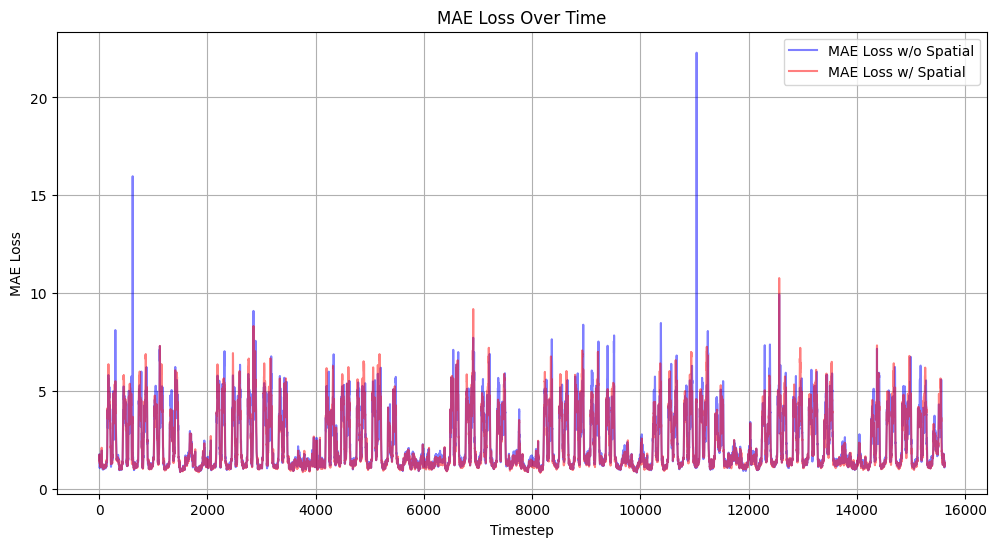

In [22]:
# Plot the original and smoothed MAE values over time
plt.figure(figsize=(12, 6))
plt.plot(timesteps_09, mae_loss_per_timestep_09, label='MAE Loss w/o Spatial', color='blue', alpha=0.5)
plt.plot(timesteps_10, mae_loss_per_timestep_10, label='MAE Loss w/ Spatial', color='red', alpha=0.5)
plt.xlabel('Timestep')
plt.ylabel('MAE Loss')
plt.title('MAE Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

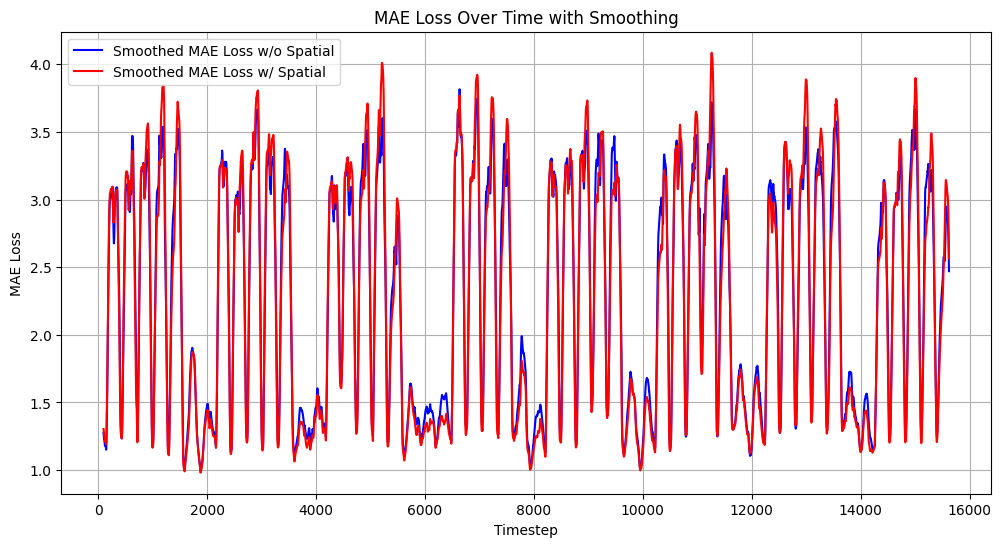

In [25]:

# Plot the original and smoothed MAE values over time
plt.figure(figsize=(12, 6))
plt.plot(smoothed_timesteps_09, smoothed_mae_09, label='Smoothed MAE Loss w/o Spatial', color='blue')
plt.plot(smoothed_timesteps_10, smoothed_mae_10, label='Smoothed MAE Loss w/ Spatial', color='red')
plt.xlabel('Timestep')
plt.ylabel('MAE Loss')
plt.title('MAE Loss Over Time with Smoothing')
plt.legend()
plt.grid(True)
plt.show()